In [1]:
import pandas as pd

In [17]:
data =pd.read_csv('EAAWaterBudget.csv')

In [18]:
data.head()

,Year,Total Recharge (1000 af),Total Discharge (1000 af),Spring Discharge (1000 af),Well Discharge (1000 af),Precipitation at San Antonio (inches)
0,1934,179.6,437.9,336.0,101.9,27.65
1,1935,1258.2,519.6,415.9,103.7,42.93
2,1936,909.6,598.2,485.5,112.7,34.11
3,1937,400.7,571.2,451.0,120.2,26.07
4,1938,432.7,557.8,437.7,120.1,23.26


In [19]:
data=data.set_index('Year')

In [20]:
data.columns = ['Recharge', 'Discharge',
       'Spring', 'Well',
       'Precipitation']

In [21]:
recharge = data[['Recharge']]


In [22]:
#echarge['Recharge']=recharge['Recharge'].astype(float)

In [23]:
recharge_10yr = recharge.rolling(10).mean()

In [26]:
recharge_10yr = recharge_10yr.dropna()

<AxesSubplot:xlabel='Year'>

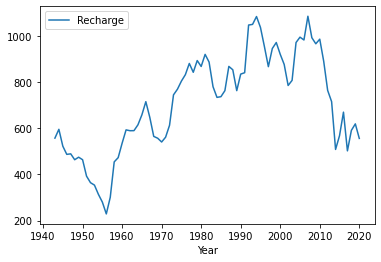

In [28]:
recharge_10yr.plot()

In [29]:
X = (recharge_10yr.index).to_numpy().reshape(-1, 1)
y = recharge_10yr["Recharge"].to_numpy()

In [30]:
from sklearn.gaussian_process.kernels import RBF

long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)

In [31]:
from sklearn.gaussian_process.kernels import ExpSineSquared

seasonal_kernel = (
    2.0**2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)

In [33]:
from sklearn.gaussian_process.kernels import RationalQuadratic

irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)

In [34]:
from sklearn.gaussian_process.kernels import WhiteKernel

noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
    noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
)

In [35]:
recharge_kernel = (
    long_term_trend_kernel + seasonal_kernel + irregularities_kernel + noise_kernel
)
recharge_kernel

50**2 * RBF(length_scale=50) + 2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)

In [37]:
from sklearn.gaussian_process import GaussianProcessRegressor

y_mean = y.mean()
gaussian_process = GaussianProcessRegressor(kernel=recharge_kernel, normalize_y=False)
gaussian_process.fit(X, y - y_mean)

C:\Anaconda3\envs\chemicals\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Anaconda3\envs\chemicals\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Anaconda3\envs\chemicals\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=50**2 * RBF(length_scale=50) + 2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01))

In [42]:
import numpy as np

#today = datetime.datetime.now()
#current_month = today.year + today.month / 12
X_test = np.linspace(start=2020, stop=2050, num=30).reshape(-1, 1)
mean_y_pred, std_y_pred = gaussian_process.predict(X_test, return_std=True)
mean_y_pred += y_mean

In [43]:
import matplotlib.pyplot as plt

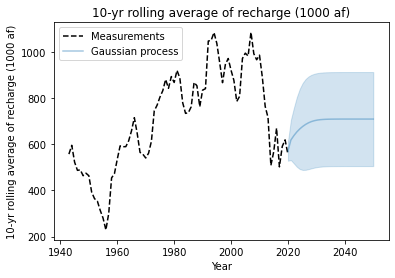

In [44]:
plt.plot(X, y, color="black", linestyle="dashed", label="Measurements")
plt.plot(X_test, mean_y_pred, color="tab:blue", alpha=0.4, label="Gaussian process")
plt.fill_between(
    X_test.ravel(),
    mean_y_pred - std_y_pred,
    mean_y_pred + std_y_pred,
    color="tab:blue",
    alpha=0.2,
)
plt.legend()
plt.xlabel("Year")
plt.ylabel("10-yr rolling average of recharge (1000 af)")
_ = plt.title(
    "10-yr rolling average of recharge (1000 af)"
)